# PSG-XGBoost

To solve the problem of endogeneity, use propensity score matching (PSM) combined with XGBoost to analyze the Internet usage

In [1]:
%pwd

'/mnt/f/ESG09_Project/Code'

In [2]:
%cd ..

/mnt/f/ESG09_Project


/home/zhang/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


## Import Package

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
from scipy import stats
import seaborn as sns
import shap
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from xgboost import XGBClassifier, XGBRegressor

## Load and Make Datasets

In [4]:
Df_Filename = os.path.join("Data", "GallupWB_Zhang47var798k6wave_v1.parquet")

In [5]:
Df = pd.read_parquet(Df_Filename)

In [6]:
Df.shape

(798604, 74)

In [7]:
Df.head()

,wave,INCOME_2,Cantril_ladder,Health_disable,Relative_have,Life_satisfaction,Living_standard_trend,Enough_food,Enough_shelter,Well_rested,...,Children_under15,Feeling_income,Born_here,Home_handline,Mobile_phone,Internet_access_available,Used_internet_recently,Phone_internet_access,COUNTRY_ISO3,Income_level
1709734,12,592300.098717,5.0,0.0,1.0,0.0,-1.0,1.0,0.0,0.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,USA,5.0
1709735,12,106614.017769,9.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,USA,5.0
1709736,12,21322.803554,6.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,USA,3.0
1709737,12,56860.809477,5.0,0.0,1.0,1.0,-0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,USA,5.0
1709738,12,33844.027641,7.0,1.0,1.0,1.0,-0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,USA,2.0


In [8]:
Df.columns

Index(['wave', 'INCOME_2', 'Cantril_ladder', 'Health_disable', 'Relative_have',
       'Life_satisfaction', 'Living_standard_trend', 'Enough_food',
       'Enough_shelter', 'Well_rested', 'Respected', 'Smile',
       'Interesting_thing', 'Enjoyment', 'Physical_pain', 'Worry', 'Sadness',
       'Stress', 'Anger', 'City_satisfaction', 'Recommended_live_place',
       'Economic_rating', 'Economic_trend', 'Local_job_outlook',
       'Satisfied_pubtran', 'Satisfied_road', 'Satisfied_edu',
       'Satisfied_qualityair', 'Satisfied_qualitywater',
       'Satisfied_healthcare', 'Satisfied_affhouse', 'Satisfied_oppofriend',
       'Good_minorities', 'Good_homo', 'Good_immigrants', 'Donated',
       'Volunteer', 'Help_stranger', 'Voice_official',
       'Local_police_confidence', 'Safety_walk', 'Stolen', 'Assualted',
       'Religion_importance', 'Children_respected', 'Children_learn',
       'Women_respected', 'Satisfied_dealpoor', 'Satisfied_Env_preservation',
       'Satisfied_Personalfreedom

### One-hot & Shuffle Conversion

In [9]:
print(Df['COUNTRY_ISO3'].dtype)

object


In [10]:
# 对 COUNTRY_ISO3 进行 one-hot 编码
onehot_encoder = OneHotEncoder(sparse_output=False, dtype=int)
country_encoded = onehot_encoder.fit_transform(Df[['COUNTRY_ISO3']])
country_columns = onehot_encoder.get_feature_names_out(['COUNTRY_ISO3'])

In [11]:
# 创建一个新的 DataFrame，包含 one-hot 编码后的国家列
country_df = pd.DataFrame(country_encoded, columns=country_columns, index=Df.index)

In [12]:
Df_new = pd.concat([Df.drop('COUNTRY_ISO3', axis=1), country_df], axis=1)

In [13]:
Df_new = Df_new.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
Df_new.head()

,wave,INCOME_2,Cantril_ladder,Health_disable,Relative_have,Life_satisfaction,Living_standard_trend,Enough_food,Enough_shelter,Well_rested,...,COUNTRY_ISO3_USA,COUNTRY_ISO3_UZB,COUNTRY_ISO3_VEN,COUNTRY_ISO3_VNM,COUNTRY_ISO3_XKX,COUNTRY_ISO3_XNC,COUNTRY_ISO3_YEM,COUNTRY_ISO3_ZAF,COUNTRY_ISO3_ZMB,COUNTRY_ISO3_ZWE
0,13,5278.624306,3.0,1.0,1.0,0.0,-0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,14,0.000000,5.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,14,5345.822529,10.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,17,10127.215850,5.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,16,7106.753699,6.0,0.0,0.0,0.0,-0.0,1.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


## PSM-XGBOOST

### 1. Data preprocessing: removing specific features

In [15]:
features_to_remove = ['Used_internet_recently', 'Phone_internet_access']
Df_new = Df_new.drop(columns=features_to_remove)

### 2. Prepare data

In [16]:
X = Df_new.drop(['Internet_access_available', 'Cantril_ladder'], axis=1)
y = Df_new['Internet_access_available']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### 3. Optimization parameters

In [18]:
def optimize_xgb_params(X_train, y_train):
    param_grid = {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3],
        'subsample': [0.8],
    }
    
    xgb_model = XGBClassifier(objective='binary:logistic', device = 'cuda', tree_method='hist', random_state=42)
    
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                               cv=3, scoring='roc_auc', n_jobs=1, verbose=2)
    
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best ROC AUC score:", grid_search.best_score_)
    
    return grid_search.best_estimator_

best_model = optimize_xgb_params(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/home/zhang/miniconda3/envs/tf/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [20:53:30] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   3.7s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   3.3s
[CV] END learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time=   3.3s
Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Best ROC AUC score: 0.9093221506559894


### 4. Evaluate the best model

In [19]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")

Test Accuracy: 0.8405
Test ROC AUC: 0.9088


### 5. Estimating propensity scores

In [20]:
def estimate_propensity_scores(df, model):
    X = df.drop(['Internet_access_available', 'Cantril_ladder'], axis=1)
    return model.predict_proba(X)[:, 1]

Df_new['propensity_score'] = estimate_propensity_scores(Df_new, best_model)

### 6. Print propensity score statistics

In [21]:
print("\nPropensity Score Statistics:")
print(Df_new['propensity_score'].describe())

print("\nPropensity Score Statistics for Internet Access Group:")
print(Df_new[Df_new['Internet_access_available'] == 1]['propensity_score'].describe())

print("\nPropensity Score Statistics for No Internet Access Group:")
print(Df_new[Df_new['Internet_access_available'] == 0]['propensity_score'].describe())


Propensity Score Statistics:
count    798604.000000
mean          0.675907
std           0.308049
min           0.008755
25%           0.443681
50%           0.795498
75%           0.943583
max           0.994704
Name: propensity_score, dtype: float64

Propensity Score Statistics for Internet Access Group:
count    539754.000000
mean          0.825871
std           0.191530
min           0.014434
25%           0.754176
50%           0.902958
75%           0.964667
max           0.994704
Name: propensity_score, dtype: float64

Propensity Score Statistics for No Internet Access Group:
count    258850.000000
mean          0.363201
std           0.267571
min           0.008755
25%           0.124115
50%           0.305863
75%           0.576887
max           0.993119
Name: propensity_score, dtype: float64


### 6. Visualizing Propensity Score Distribution

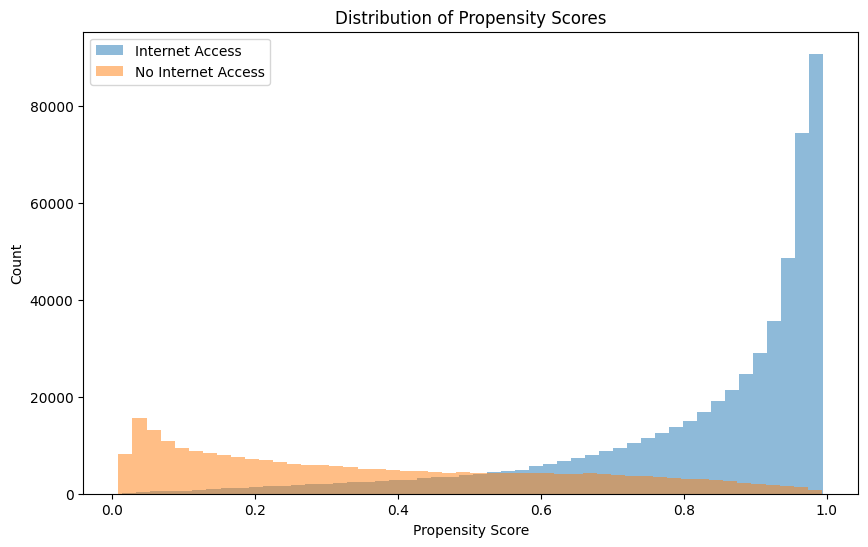

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(Df_new[Df_new['Internet_access_available'] == 1]['propensity_score'], 
         bins=50, alpha=0.5, label='Internet Access')
plt.hist(Df_new[Df_new['Internet_access_available'] == 0]['propensity_score'], 
         bins=50, alpha=0.5, label='No Internet Access')
plt.xlabel('Propensity Score')
plt.ylabel('Count')
plt.legend()
plt.title('Distribution of Propensity Scores')
plt.show()

### 7. Optimized sample matching function

In [23]:
def match_samples_optimized(df, caliper=0.2, n_jobs=-1):
    treated = df[df['Internet_access_available'] == 1]
    control = df[df['Internet_access_available'] == 0]
    
    # 使用NearestNeighbors进行快速匹配
    nn = NearestNeighbors(n_neighbors=1, metric='euclidean', n_jobs=n_jobs)
    nn.fit(control[['propensity_score']])
    
    distances, indices = nn.kneighbors(treated[['propensity_score']])
    
    # 向量化操作进行匹配
    valid_matches = distances.flatten() < caliper
    
    matched_treated = treated[valid_matches]
    matched_control = control.iloc[indices.flatten()[valid_matches]]
    
    # 合并匹配结果
    matched_df = pd.concat([matched_treated, matched_control])
    
    return matched_df

matched_df = match_samples_optimized(Df_new)

### 8. Group analysis

In [24]:
def train_and_analyze(df, internet_access):
    subset = df[df['Internet_access_available'] == internet_access]
    X = subset.drop(['Cantril_ladder', 'Internet_access_available', 'propensity_score'], axis=1)
    y = subset['Cantril_ladder']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    
    model = XGBRegressor(objective='reg:squarederror', device = 'cuda', tree_method='hist', n_estimators=1000, 
                         learning_rate=0.01, max_depth=6, subsample=0.8, 
                         random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared score for {'Internet Access' if internet_access else 'No Internet Access'}: {r2:.4f}")
    
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    
    return model, shap_values, X_test

In [25]:
# Train the models separately and get the SHAP values

In [26]:
model_with_internet, shap_values_with, X_test_with = train_and_analyze(matched_df, 1)
model_without_internet, shap_values_without, X_test_without = train_and_analyze(matched_df, 0)

R-squared score for Internet Access: 0.3276
R-squared score for No Internet Access: 0.4033


### 9. SHAP value analysis

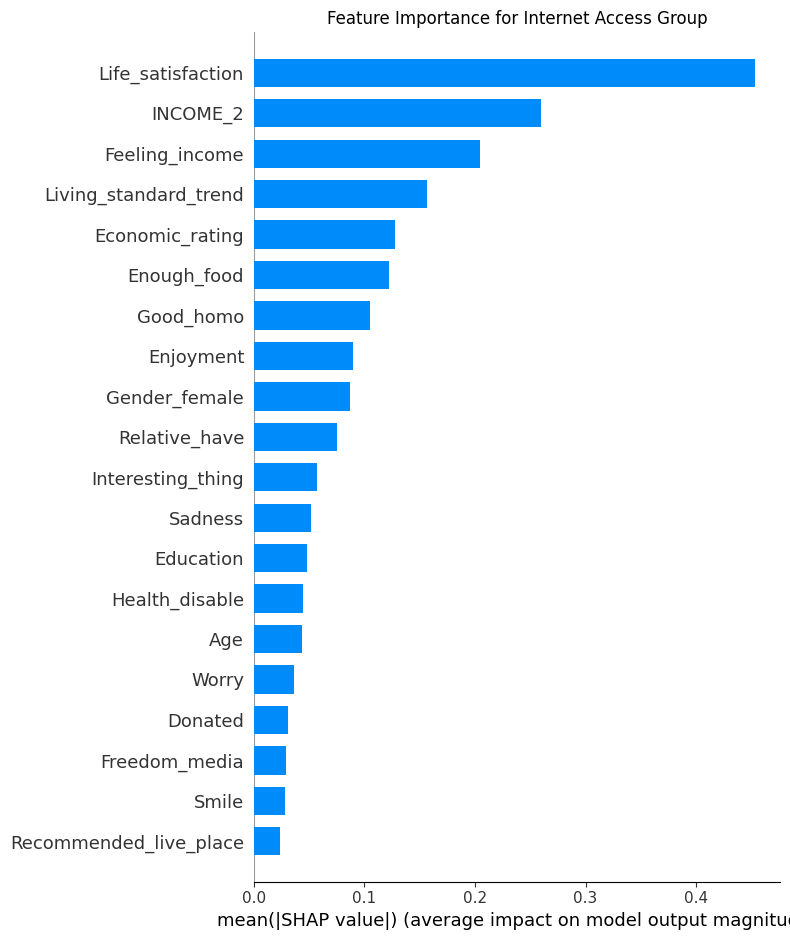

In [27]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_with, X_test_with, plot_type="bar", show=False)
plt.title("Feature Importance for Internet Access Group")
plt.tight_layout()
plt.show()

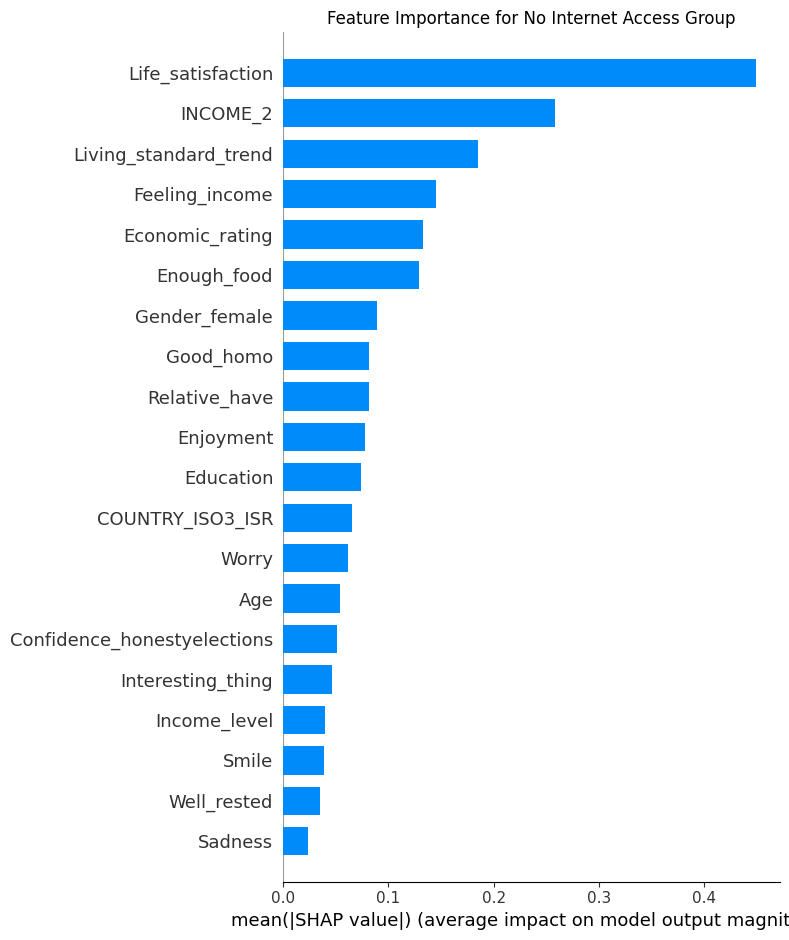

In [28]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_without, X_test_without, plot_type="bar", show=False)
plt.title("Feature Importance for No Internet Access Group")
plt.tight_layout()
plt.show()

### 10. Comparing variable effects

In [29]:
def compare_variable_impact(variable_name):
    impact_with = np.abs(shap_values_with[:, X_test_with.columns.get_loc(variable_name)]).mean()
    impact_without = np.abs(shap_values_without[:, X_test_without.columns.get_loc(variable_name)]).mean()
    
    print(f"Impact of {variable_name} on Cantril_ladder:")
    print(f"  With Internet Access: {impact_with:.4f}")
    print(f"  Without Internet Access: {impact_without:.4f}")
    print(f"  Difference: {impact_with - impact_without:.4f}")

variables_of_interest = ['INCOME_2', 'Education', 'Age', 'Employment', 'Health_disable', 'Life_satisfaction']
for var in variables_of_interest:
    compare_variable_impact(var)

Impact of INCOME_2 on Cantril_ladder:
  With Internet Access: 0.2599
  Without Internet Access: 0.2583
  Difference: 0.0015
Impact of Education on Cantril_ladder:
  With Internet Access: 0.0481
  Without Internet Access: 0.0740
  Difference: -0.0259
Impact of Age on Cantril_ladder:
  With Internet Access: 0.0438
  Without Internet Access: 0.0544
  Difference: -0.0107
Impact of Employment on Cantril_ladder:
  With Internet Access: 0.0013
  Without Internet Access: 0.0144
  Difference: -0.0131
Impact of Health_disable on Cantril_ladder:
  With Internet Access: 0.0444
  Without Internet Access: 0.0213
  Difference: 0.0231
Impact of Life_satisfaction on Cantril_ladder:
  With Internet Access: 0.4531
  Without Internet Access: 0.4493
  Difference: 0.0038


### 11. Estimating the overall impact of Internet access

In [30]:
internet_effect = np.mean(matched_df[matched_df['Internet_access_available'] == 1]['Cantril_ladder']) - \
                  np.mean(matched_df[matched_df['Internet_access_available'] == 0]['Cantril_ladder'])
print(f"Estimated overall effect of internet access on Cantril_ladder: {internet_effect:.4f}")

Estimated overall effect of internet access on Cantril_ladder: 0.2162
